# Face detection and BMI/Age/Sex prediction

The model provides end-to-end capability of detecting faces and predicting the BMI, Age and Gender for each person. 

The architecture of the model is described as below:

![](./img/model_structure.jpg)


## Face detection

Face detection is done by `MTCNN`, which is able to detect multiple faces within an image and draw the bounding box for each faces.  

It serves two purposes for this project:

### 1) preprocess and align the facial features of image.

Prior model training, each image is preprocessed by `MTCNN` to extract faces and crop images to focus on the facial part. The cropped images are saved and used to train the model in later part.

Illustration of face alignment:
![](./img/mtcnn_face_alignment.jpg)

### 2) enable prediction for multiple persons in the same image.

In inference phase, faces will be detected from the input image. For each face, it will go through the same preprocssing and make the predictions.

Illustration of ability to predict for multiple faces:
![](./img/detect_predict_multi_faces.png)

## Multi-task prediction

In vanilla CNN architecture, convolution blocks are followed by the dense layers to make output the prediction. In a naive implementation, we can build 3 models to predict BMI, age and gender individually. However, there is a strong drawback that 3 models are required to be trained and serialized separately, which drastically increases the maintenance efforts.

|   |
|---|
|`[input image] => [VGG16] => [dense layers] => [BMI]`|
|`[input image] => [VGG16] => [dense layers] => [AGE]`|
|`[input image] => [VGG16] => [dense layers] => [SEX]`|

Since we are going to predict `BMI`, `Age`, `Sex` from the same image, we can share the same backbone for the three different prediction heads and hence only one model will be maintained.

|    |
|----|
|`[input image] => [VGG16] => [separate dense layers] x3 => weighted([BMI], [AGE], [SEX])`|

This is the most simplified multi-task learning structure, which assumed independent tasks and hence separate dense layers were used for each head. Other research such as `Deep Relationship Networks`, used `matrix priors` to model the relationship between tasks.

![](https://ruder.io/content/images/2017/05/relationship_networks.png)
_A Deep Relationship Network with shared convolutional and task-specific fully connected layers with matrix priors (Long and Wang, 2015)._
 
## Reference
 * MTCNN: [https://github.com/ipazc/mtcnn](https://github.com/ipazc/mtcnn)
 * VGGFace: [https://github.com/rcmalli/keras-vggface](https://github.com/rcmalli/keras-vggface)

In [1]:
mode = 'train' #'train' or 'predict'
model_type = 'vgg16'
model_tag = 'seqMT'
model_id = '{:s}_{:s}'.format(model_type, model_tag)
model_dir = './saved_model/model_{:s}.h5'.format(model_id)
bs = 8
epochs = 2
freeze_backbone = True # True => transfer learning; False => train from scratch

In [2]:
import pandas as pd
import os
import json
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
%matplotlib inline
from matplotlib import pyplot as plt
from scripts.models import FacePrediction
from pathlib import Path
import glob

allimages = os.listdir('./data/face_aligned/')
train = pd.read_csv('./data/train.csv')
valid = pd.read_csv('./data/valid.csv')

train = train.loc[train['index'].isin(allimages)]
valid = valid.loc[valid['index'].isin(allimages)]

/Users/amandachau/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# create metrics, model dirs
Path('./metrics').mkdir(parents = True, exist_ok = True)
Path('./saved_model').mkdir(parents = True, exist_ok = True)

## Data

This is fairly small dataset, which comprises 1530 records and  16 columns.

* sex imbalance: 80% of the data is male
* age is near truncated normal distribution. min Age is 18, average Age is 34.
* race is dominated by Black and White. Asian samples are very limited.
* BMI is normal distrbuted, with mean at 26.

* no obvious correlation found between BMI and Age, Sex.

In [4]:
data = pd.concat([train, valid])
data[['age','race','sex','bmi','index']].head()

age   race   sex        bmi       index
0   54  Black  Male  39.051641  248038.jpg
1   26  Black  Male  29.288731  250464.jpg
2   21  Black  Male  23.028211  270020.jpg
3   29  White  Male  29.529925  277774.jpg
4   18  White  Male  19.005974  279426.jpg

## Modify Model

In [5]:
# keras vggface model
from keras.engine import Model
from keras.layers import Flatten, Dense, Input, Dropout, Activation, BatchNormalization, Add
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.preprocessing import image

class FP_MT(FacePrediction):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def define_model(self, hidden_dim = 128, drop_rate=0.0, freeze_backbone = True):
        
        if self.model_type == 'vgg16_fc6':
            vgg_model = VGGFace(model = 'vgg16', include_top=True, input_shape=(224, 224, 3))
            last_layer = vgg_model.get_layer('fc6').output
            flatten = Activation('relu')(last_layer)
        else:
            vgg_model = VGGFace(model = self.model_type, include_top=False, input_shape=(224, 224, 3))
            last_layer = vgg_model.output
            flatten = Flatten()(last_layer)
        
        if freeze_backbone:
            for layer in vgg_model.layers:
                layer.trainable = False
                
        def block(flatten, name):
            x = Dense(hidden_dim, name=name + '_fc1')(flatten)
            x = BatchNormalization(name = name + '_bn1')(x)
            x = Activation('relu', name = name+'_act1')(x)
            x = Dropout(drop_rate)(x)
            x = Dense(hidden_dim, name=name + '_fc2')(x)
            x = BatchNormalization(name = name + '_bn2')(x)
            x = Activation('relu', name = name+'_act2')(x)
            x = Dropout(drop_rate)(x)
            return x
        
        x = block(flatten, name = 'sex')
        out_sex = Dense(1, activation = 'sigmoid', name = 'sex')(x)        
        
        # residual connection to age
        x1 = Dense(hidden_dim)(flatten)
        x1 = Add()([x1, x])
        x1 = block(x1, name = 'age')
        out_age = Dense(1, activation='linear', name='age')(x1)
        
        # residual connection to bmi
        x2 = Dense(hidden_dim)(flatten)
        x2 = Add()([x2, x])
        x2 = block(x2, name = 'bmi')
        out_bmi = Dense(1, activation='linear', name='bmi')(x2)
        
        custom_vgg_model = Model(vgg_model.input, [out_bmi, out_age, out_sex])
        custom_vgg_model.compile('adam', 
                                 {'bmi':'mae','age':'mae','sex':'binary_crossentropy'},
                                 {'sex': 'accuracy'}, 
                                 loss_weights={'bmi': 0.8, 'age':0.1, 'sex':0.1})

        self.model = custom_vgg_model

## Training

In [6]:
es = EarlyStopping(patience=3)
ckp = ModelCheckpoint(model_dir, save_best_only=True, save_weights_only=True, verbose=1)
tb = TensorBoard('./tb/%s'%(model_type))
callbacks = [es, ckp, tb]

model = FP_MT(img_dir = './data/face_aligned/', model_type = model_type)
model.define_model(freeze_backbone = freeze_backbone)
model.model.summary()
if mode == 'train':
    model.train(train, valid, bs = bs, epochs = epochs, callbacks = callbacks)
else:
    model.load_weights(model_dir)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 224, 224, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 112, 112, 64) 0           conv1_2[0][0]                    
____________________________________________________________________________________________

/Users/amandachau/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


152/152 [==============================] - 204s 1s/step - loss: 22.7190 - bmi_loss: 24.4452 - age_loss: 31.3642 - sex_loss: 0.2639 - sex_accuracy: 0.8986 - val_loss: 12.7202 - val_bmi_loss: 13.5488 - val_age_loss: 18.7263 - val_sex_loss: 0.0848 - val_sex_accuracy: 0.9656

Epoch 00001: val_loss improved from inf to 12.72017, saving model to ./saved_model/model_vgg16_seqMT.h5
Epoch 2/2
152/152 [==============================] - 206s 1s/step - loss: 11.1766 - bmi_loss: 11.8166 - age_loss: 17.1570 - sex_loss: 0.0765 - sex_accuracy: 0.9795 - val_loss: 6.1284 - val_bmi_loss: 6.5768 - val_age_loss: 8.5873 - val_sex_loss: 0.0824 - val_sex_accuracy: 0.9656

Epoch 00002: val_loss improved from 12.72017 to 6.12844, saving model to ./saved_model/model_vgg16_seqMT.h5


## Evaluations

In [7]:
metrics = model.evaulate(valid)
metrics['model'] = model_id
with open('./metrics/{:s}.json'.format(model_id), 'w') as f:
    json.dump(metrics, f)
metrics = []
for i in glob.glob('./metrics/*.json'):
    with open(i, 'r') as f:
        res = json.load(f)
    metrics.append(res)
metrics = pd.DataFrame(metrics)
metrics['model'] = metrics['model'].apply(lambda i: '* ' + i if i == model_id else i)
metrics.set_index('model').round(3)

bmi_mae  bmi_cor  age_mae  sex_auc
model                                            
* vgg16_seqMT    6.519    0.115    8.154    0.997
vgg16            5.830    0.194    8.399    0.999

## Predictions

### predict from a single image

In [8]:
model.predict('./data/test/test_aligned/trump.jpg')

[array([[23.21455]], dtype=float32),
 array([[45.872738]], dtype=float32),
 array([[0.06802326]], dtype=float32)]

### predict from a directory

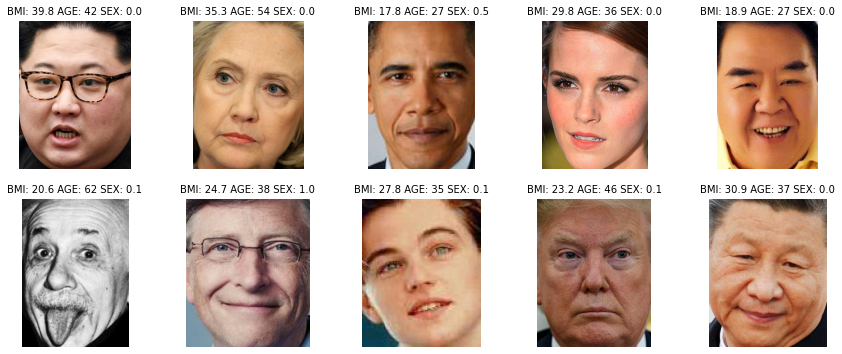

In [9]:
preds = model.predict('./data/test/test_aligned/', show_img = True)

In [10]:
model.predict_df('./data/test/test_aligned')

img        bmi        age     sex  sex_prob
0      Kim Jong-un.jpg  39.767845  41.826077  Female  0.000311
1   hilary_clinton.jpg  35.273201  54.196327  Female  0.000010
2     barack-obama.jpg  17.835783  26.963837    Male  0.479132
3      emma_watson.jpg  29.831551  35.874969  Female  0.000360
4       kent_zheng.jpg  18.909317  26.745415  Female  0.013495
5  albert-einstein.jpg  20.557642  61.772907    Male  0.098599
6       bill-gates.jpg  24.712568  38.349979    Male  0.960125
7        leonardo.jpeg  27.777384  34.968903    Male  0.094887
8            trump.jpg  23.214544  45.872711    Male  0.068023
9               xi.jpg  30.891920  36.901394  Female  0.017470

### predict multiple faces

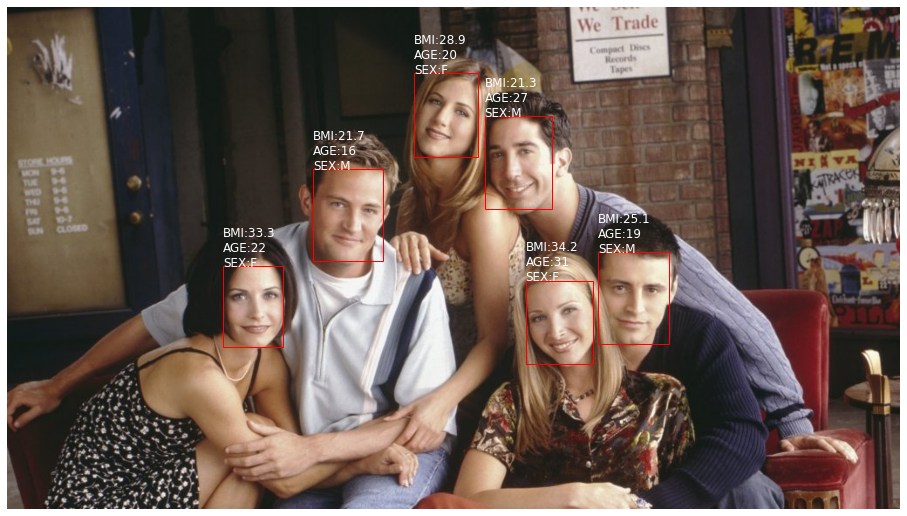

In [11]:
preds = model.predict_faces('./data/test/multi_face/friends.jpg', color = 'white')

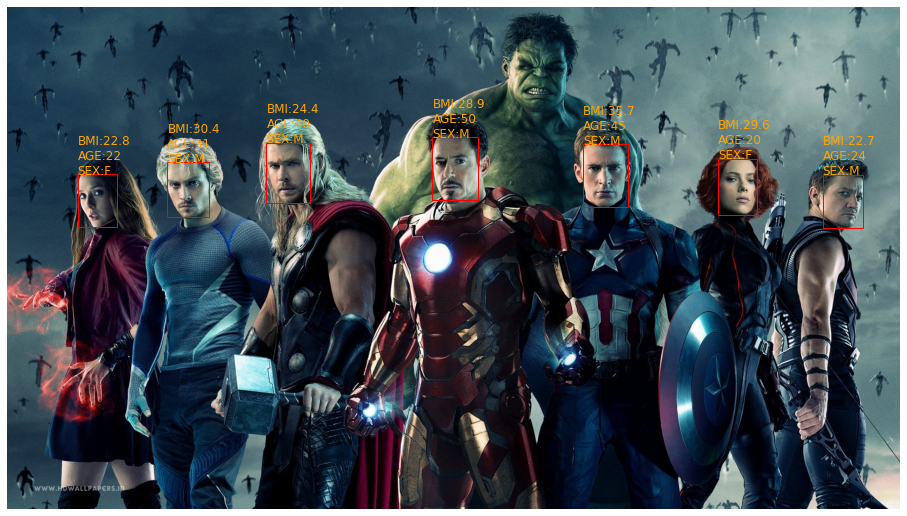

In [12]:
preds = model.predict_faces('./data/test/multi_face/avengers.jpg', color = 'orange')

Cleave_2021_Summer.png


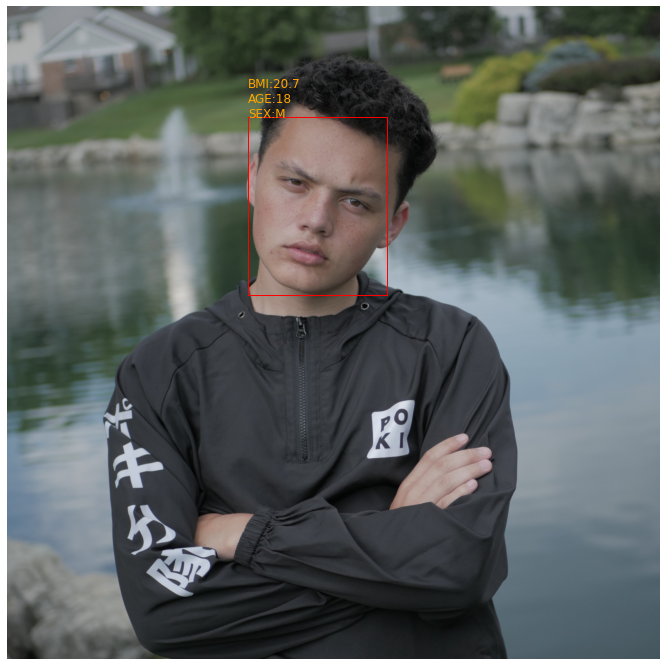

Darshan_2022_Spring.png


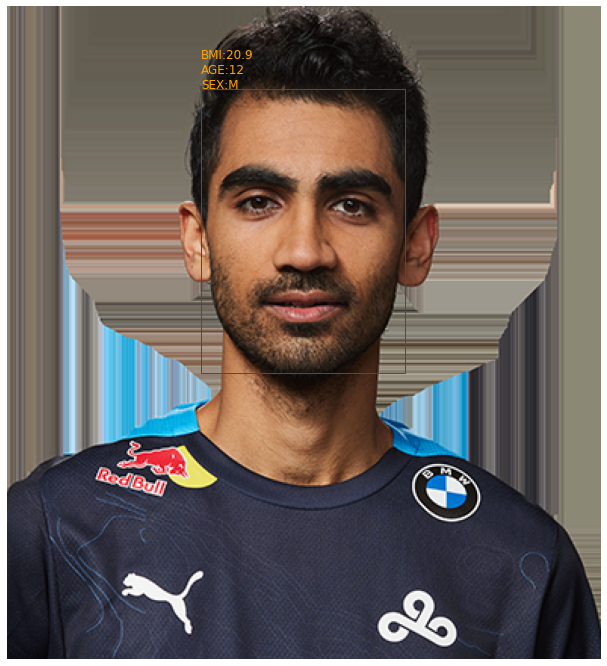

Darshan_2018_Spring.png


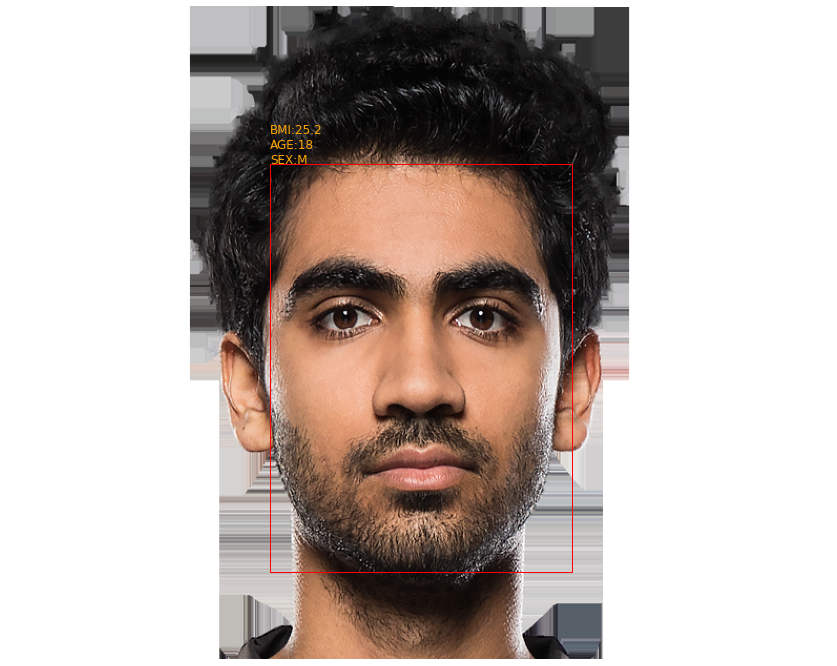

Darshan_2022_Summer.png


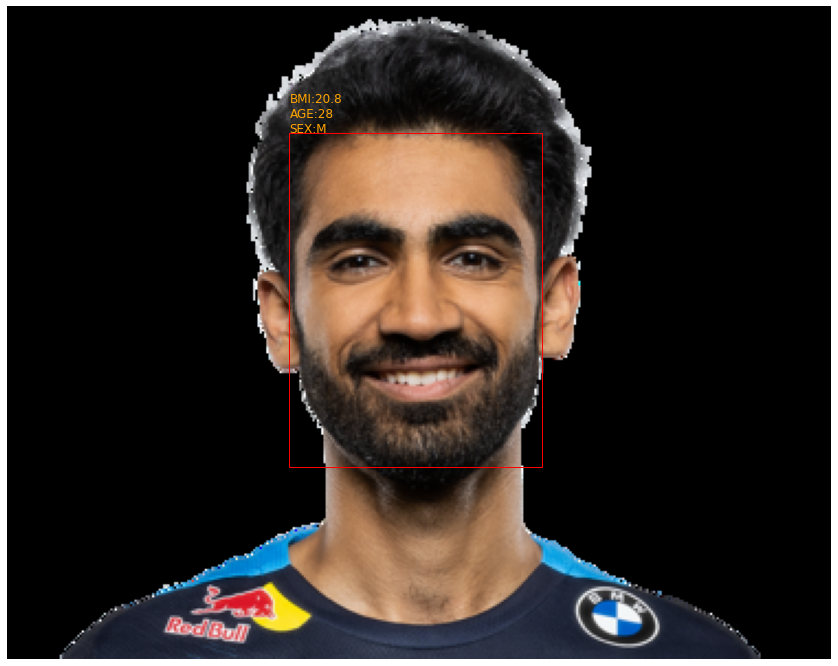

Cleave_2021_Spring.png
Skipping image: ./data/test/bmi_test/Cleave_2021_Spring.png (corrupt or unsupported format)
Darshan_2018_Summer.png


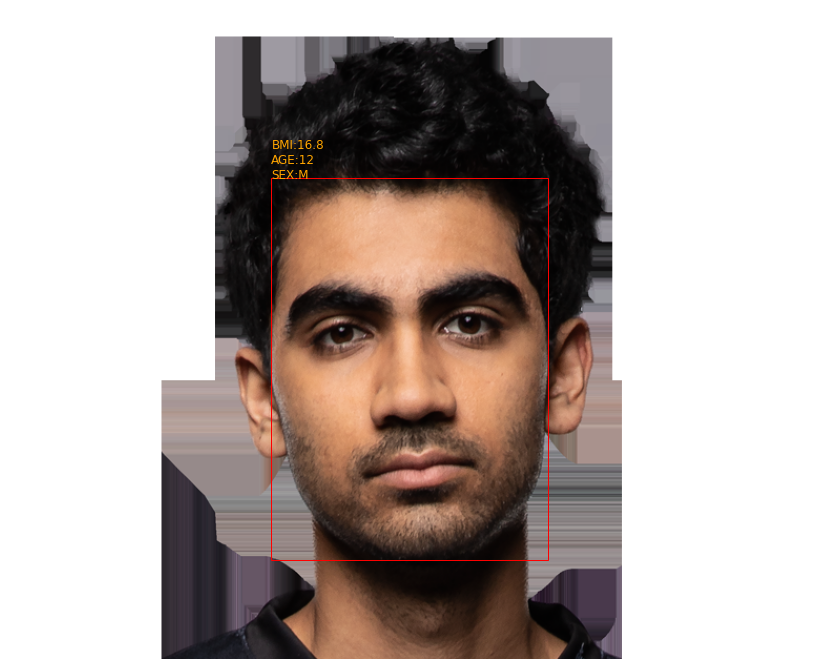

Darshan_2017_Spring.png


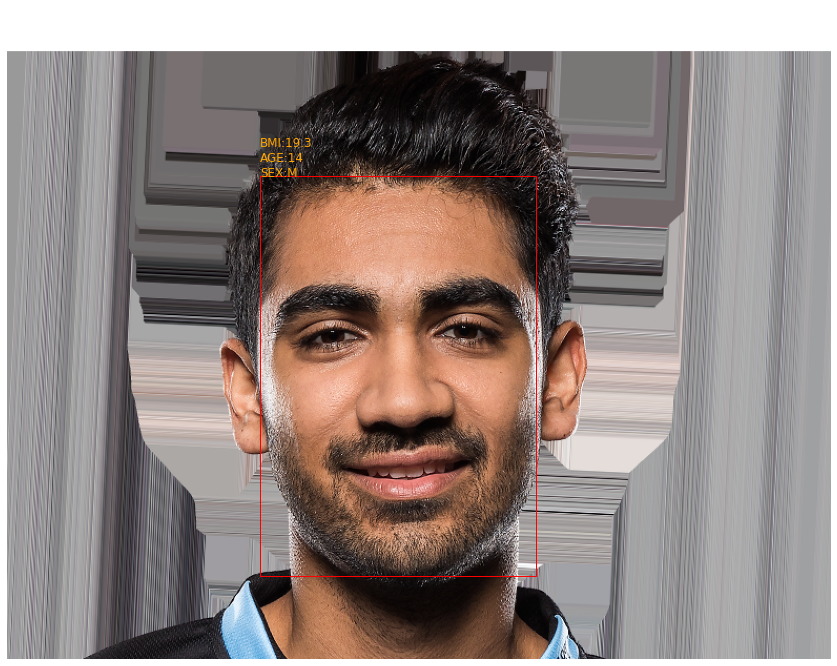

Darshan_2019_Spring.png


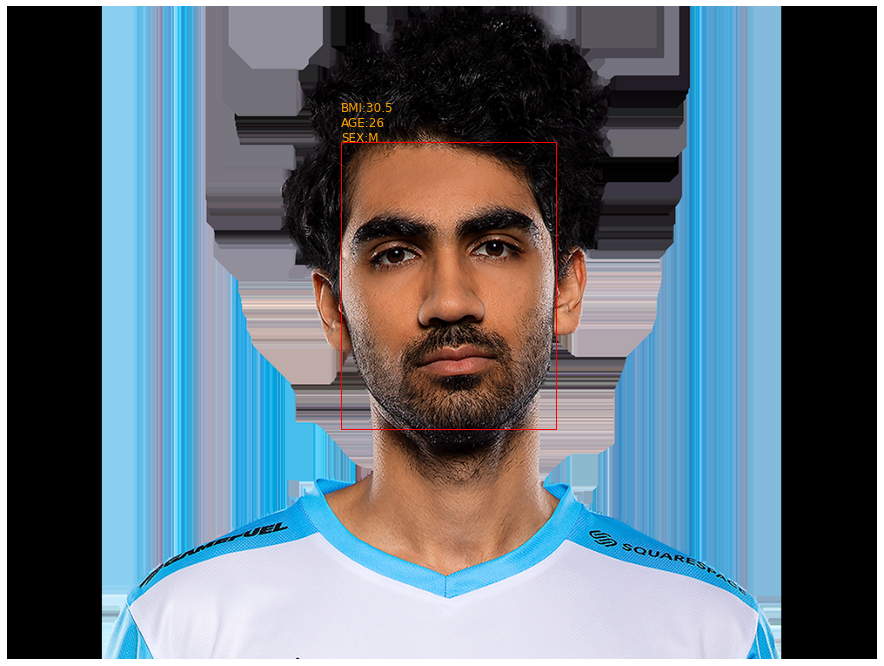

Darshan_2016_Summer.png


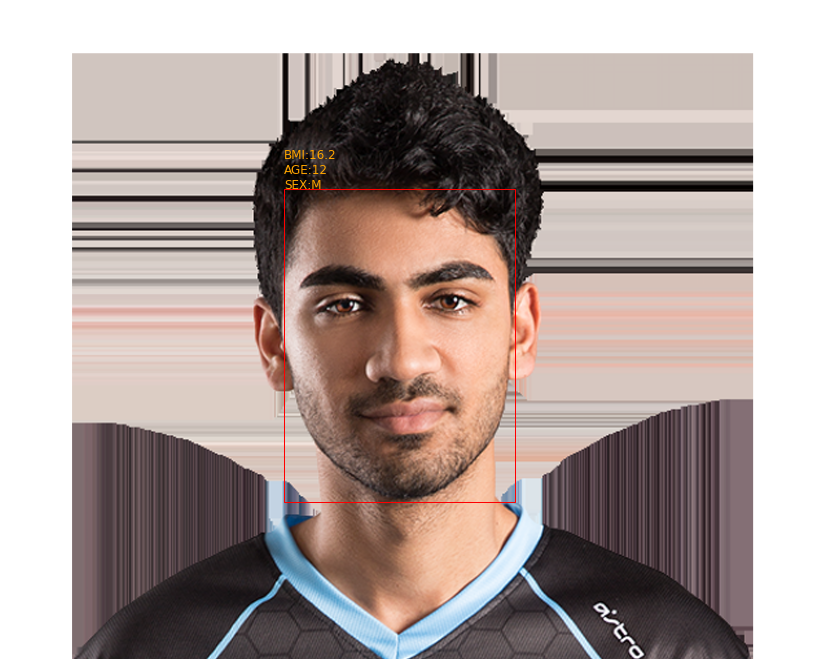

Darshan_2021_Spring.png


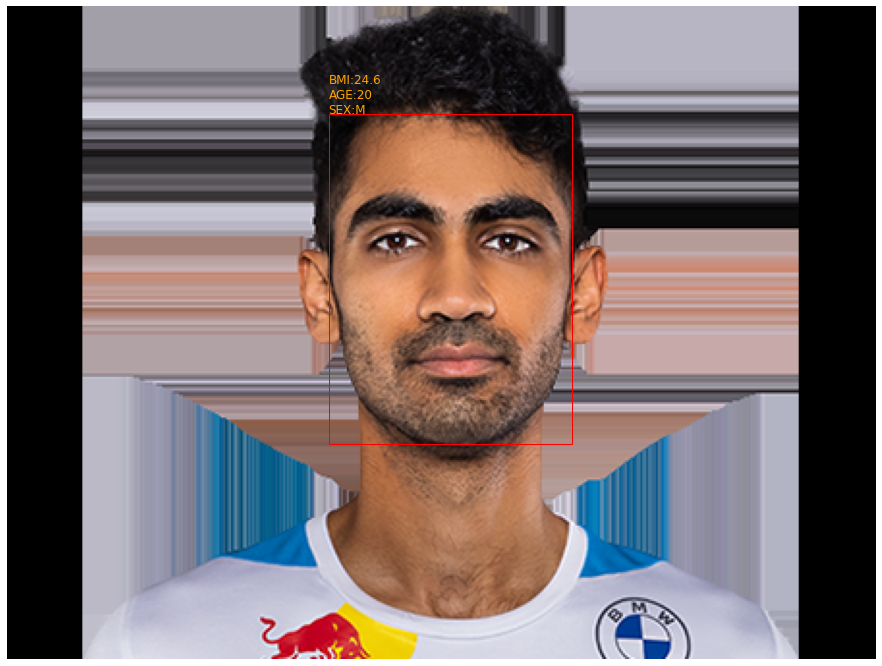

Darshan_2016_Spring.png


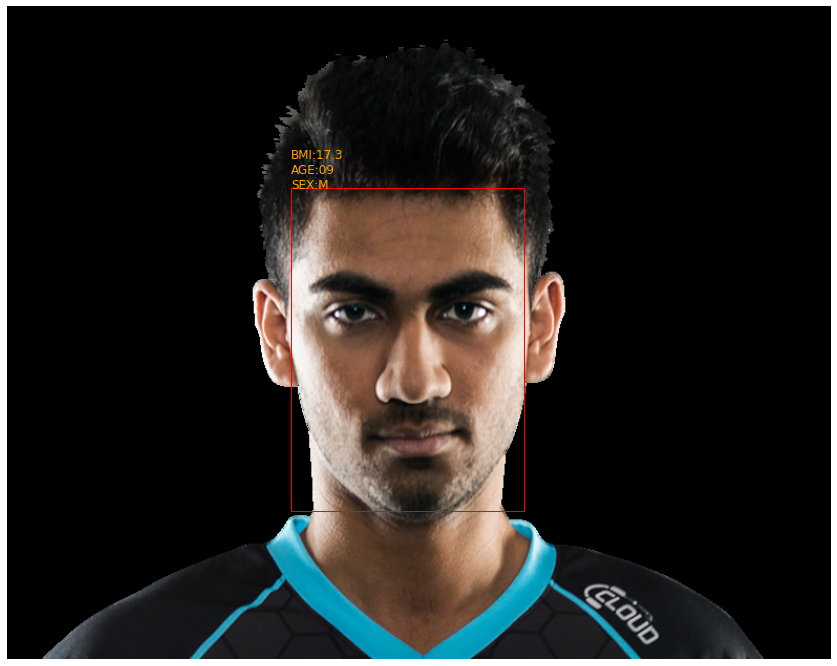

Darshan_2016_Summer_2.png


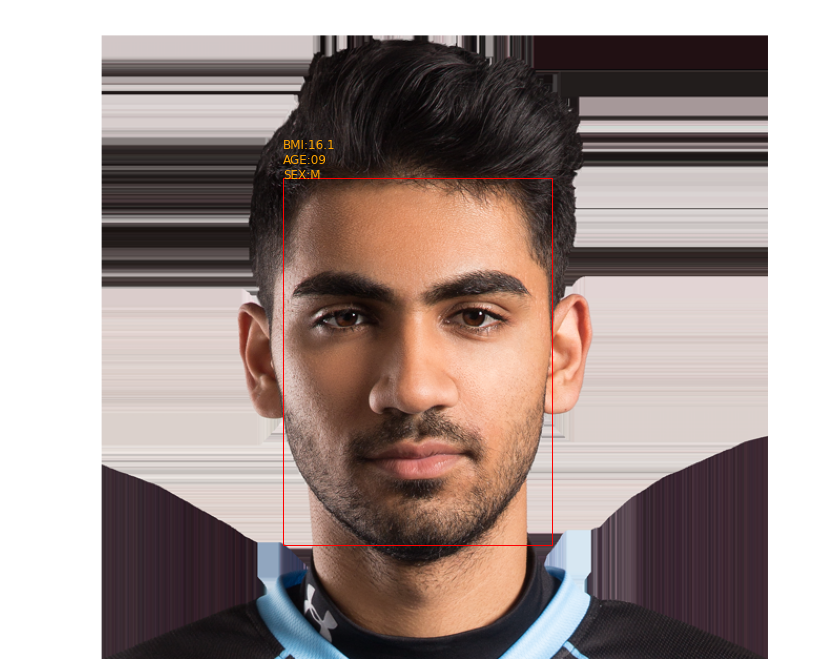

In [13]:
from PIL import Image

directory = './data/test/bmi_test/'
for item in os.listdir(directory):
    print(item)
    item_path = os.path.join(directory, item)
    try:
        image = Image.open(item_path)
        model.predict_faces(item_path, color='orange')
    except Image.UnidentifiedImageError:
        print(f"Skipping image: {item_path} (corrupt or unsupported format)")
        continue